# Latent Net implementation

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

#torch.set_default_dtype(torch.float32)

In [2]:
# Install PyG
# try:
#   import torch_geometric
# except ImportError:
#   !pip3 install torch_geometric
#   import torch_geometric

In [3]:
import numpy as np

In [4]:
# Import some utils from gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gnn_time')
else:
    sys.path.append('./..')
    
from gca_rom import pde, scaling
import dynamics_network, initialization, loader, preprocessing_scale, train

In [5]:
variable = 'U'
problem_name = 'lid_cavity'
print("\nProblem: ", problem_name)
print("Variable: ", variable)



Problem:  lid_cavity
Variable:  U


In [6]:
# Parameters to be set

#preset = [3, 2, 2, 2, 1, 3, 3, 1]

train_rate = 70 ###### Shrink train dataset
dim_latent = 10
epochs = 50
dt = 1e-1 # For forward euler
scaling_type = 2 # scale only against the features
scaler_number = 3 # type of scaling function. 3 -> standard

argv = [problem_name, variable, scaling_type, scaler_number, train_rate, 1e-3, 1e-3, dim_latent, dt, epochs]
HyperParams = dynamics_network.HyperParams(argv)

# Initialization

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'

# Import the data from the mat file 
dataset = loader.LoadDataset(dataset_dir, variable)

# Delete the initial condition of each case
dataset.U = np.delete(dataset.U, np.s_[::10], 1)

In [9]:
# New approach for the parameters. Just store u(t) for all snapshots and the time t. if necessary, interpolate u(t) linearly

if 'google.colab' in str(get_ipython()):
    u_t_latent = np.load('/content/gnn_time/lid_driven_cavity_fenics/u_t_latent.npy')
else:
    u_t_latent = np.load('../lid_driven_cavity_fenics/u_t_latent.npy')

time = np.linspace(0.2, 1.8, 9)

# Get rid of the initial condition evaluation (0.0)
u_t_latent = np.delete(u_t_latent, np.s_[::10], 0)   
u_t_tensor = torch.from_numpy(u_t_latent)
time_tensor = torch.from_numpy(time)
print("Number of simulations:", len(u_t_latent))
print("Number of instants of time:", len(time))



Number of simulations: 180
Number of instants of time: 9


In [10]:
train_loader, test_loader, scaler_all,\
scaler_test, VAR_all, VAR_test, train_snapshots,\
test_snapshots, position_dataset = preprocessing_scale.process_and_scale_dataset(dataset, HyperParams)

Number of nodes processed:  15681
Number of shapshots processed:  180


# Define the architecture

In [11]:
# The dynamics net takes u(t) as input and s(t)
dyn_input_size = 1 + HyperParams.dim_latent
dyn_hidden_size = 9
dim = 2 # we are in 2D

rec_input_size = dim*HyperParams.batch_size_pos + HyperParams.dim_latent
rec_hidden_size = dyn_hidden_size
rec_output_size = HyperParams.batch_size_pos


dyn_model = dynamics_network.DynNet(dyn_input_size, dyn_hidden_size, HyperParams.dim_latent)
rec_model = dynamics_network.RecNet(rec_input_size, rec_hidden_size, rec_output_size)
dyn_model = dyn_model.to(device)
rec_model = rec_model.to(device)

# Define optimizers for both models
dyn_optimizer = torch.optim.Adam(dyn_model.parameters(), lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
rec_optimizer = torch.optim.Adam(rec_model.parameters(), lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
dyn_scheduler = torch.optim.lr_scheduler.MultiStepLR(dyn_optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)
rec_scheduler = torch.optim.lr_scheduler.MultiStepLR(rec_optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train the network

In [12]:
import cProfile
############# Shrink the test dataset ##############
#test_snapshots = test_snapshots[:5]
train_history, test_history = train.train_dyn_rec_nets(dyn_model, rec_model, dyn_optimizer, rec_optimizer, dyn_scheduler, rec_scheduler,\
                          device, u_t_tensor ,time_tensor, train_loader, test_loader, position_dataset, train_snapshots, test_snapshots, HyperParams)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:14<00:00, 14.27s/it, Loss(training)=9.4, Loss(test)=139]


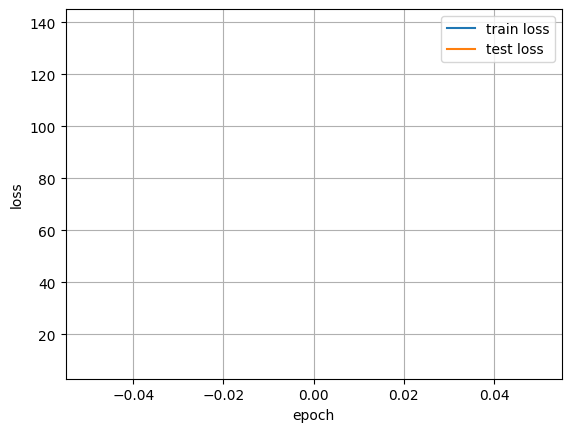

In [13]:
from matplotlib import pyplot as plt

plt.plot(train_history['loss'], label='train loss')
plt.plot(test_history['loss'], label='test loss')
plt.legend()

plt.grid()

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
